In [2]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  


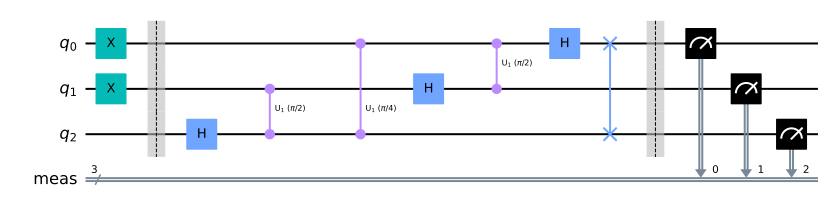

In [3]:
qc = QuantumCircuit(3)
qc.x(0)
qc.x(1)
qc.barrier()
qc.h(2)
qc.cu1(pi/2, 1, 2)
qc.cu1(pi/4, 0, 2)
qc.h(1)
qc.cu1(pi/2, 0, 1) # CROT from qubit 0 to qubit 1
qc.h(0)
qc.swap(0,2)
qc.measure_all()
qc.draw('mpl')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  if __name__ == '__main__':


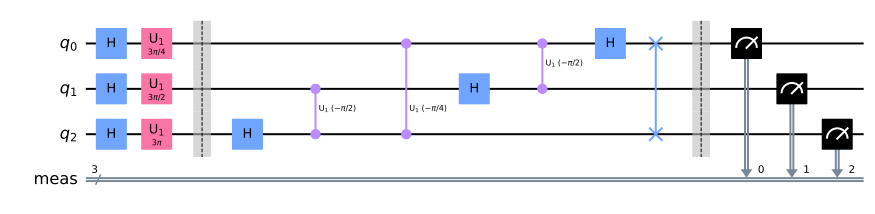

In [3]:
qc_inv = QuantumCircuit(3)
for qubit in range(3):
    qc_inv.h(qubit)
qc_inv.u1(3*pi/4,0)
qc_inv.u1(3*pi/2,1)
qc_inv.u1(3*pi,2)
qc_inv.barrier()
qc_inv.h(2)
qc_inv.cu1(-pi/2, 2, 1)
qc_inv.cu1(-pi/4, 2, 0)
qc_inv.h(1)
qc_inv.cu1(-pi/2, 1, 0) # CROT from qubit 0 to qubit 1
qc_inv.h(0)
qc_inv.swap(0,2)
qc_inv.measure_all()
qc_inv.draw('mpl')

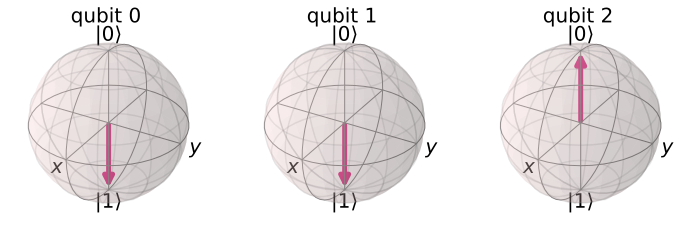

In [4]:
backend = Aer.get_backend("statevector_simulator")
statevector = execute(qc_inv, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

In [22]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
nqubits = 3
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = device = provider.get_backend('ibmq_valencia')
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2020-12-05 21:01:14,617: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_valencia


In [23]:
shots = 2048
job = execute(qc_inv, backend=backend, shots=shots, optimization_level=3)
job_monitor(job)

Job Status: job has successfully run


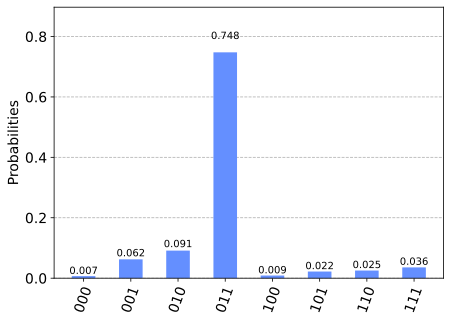

In [24]:
device_result = job.result()
plot_histogram(device_result.get_counts(qc_inv))

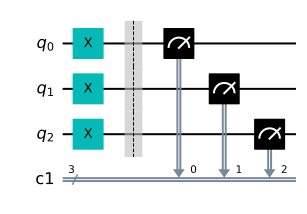

In [25]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr=qc_inv.qregs[0], circlabel='measurement_calibration')
cal_circuits[7].draw(output='mpl')

In [26]:
cal_job = execute(cal_circuits, backend=backend, shots=8192, optimization_level=0)
#print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

Job Status: job has successfully run


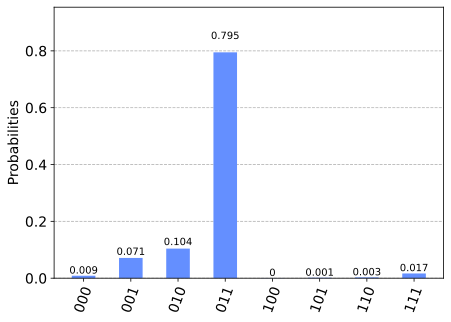

In [27]:
plot_histogram(cal_results.get_counts(cal_circuits[3]))

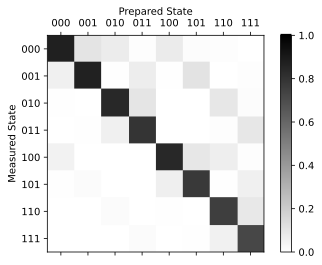

In [28]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_fitter.plot_calibration()

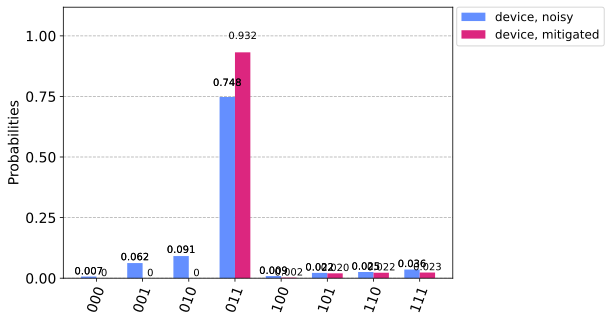

In [29]:
meas_filter = meas_fitter.filter
mitigated_result = meas_filter.apply(device_result)
device_counts = device_result.get_counts(qc_inv)
mitigated_counts = mitigated_result.get_counts(qc_inv)
plot_histogram([device_counts, mitigated_counts], legend=['device, noisy', 'device, mitigated'])

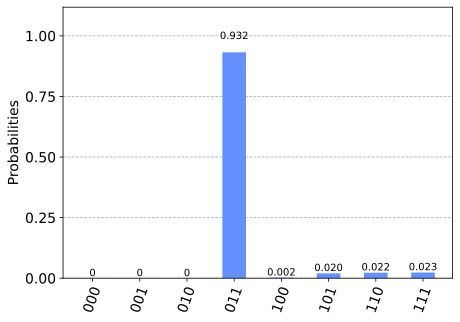

In [34]:
plot_histogram([mitigated_counts])